In [1]:
pip install chardet

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Current working directory: /Users/kwklun/llm-portfolio-manager
Files in directory: ['parquet_desc.txt', 'backtesting.py', 'trim_crsp_dsf_.py', 'data_mfin_7037_2024', '.DS_Store', 'parquet_desc_new.txt', 'config.py', 'requirements.txt', 'new_build_model_arima.ipynb', 'data_trimmer.py', 'arima', 'arima_backtest_results', 'stock_price.py', 'random_forest', 'comparative_analysis.ipynb', 'rf_backtest_results', '__pycache__', 'describe_parquet.py', 'readme.md', 'parquet_desc_data_trimmed.txt', 'sample_data', '.gitignore', '.venv', 'index', 'llm_advice.py', 'myenv', '.git', 'main.py', 'financial_news.py', 'data_trimmed', 'test.ipynb']
Loaded 503 S&P 500 tickers from index/sp500_constituents.csv
Encoding error with index/nasdaq_100.csv: 'utf-8' codec can't decode byte 0xa0 in position 19: invalid start byte. Attempting to detect encoding...
Detected encoding: ISO-8859-1
Columns in index/nasdaq_100.csv: ['Company', 'Ticker', 'GICS\xa0Sector', 'GICS\xa0Sub-Industry']
Loaded 101 Nasdaq-100 ticker

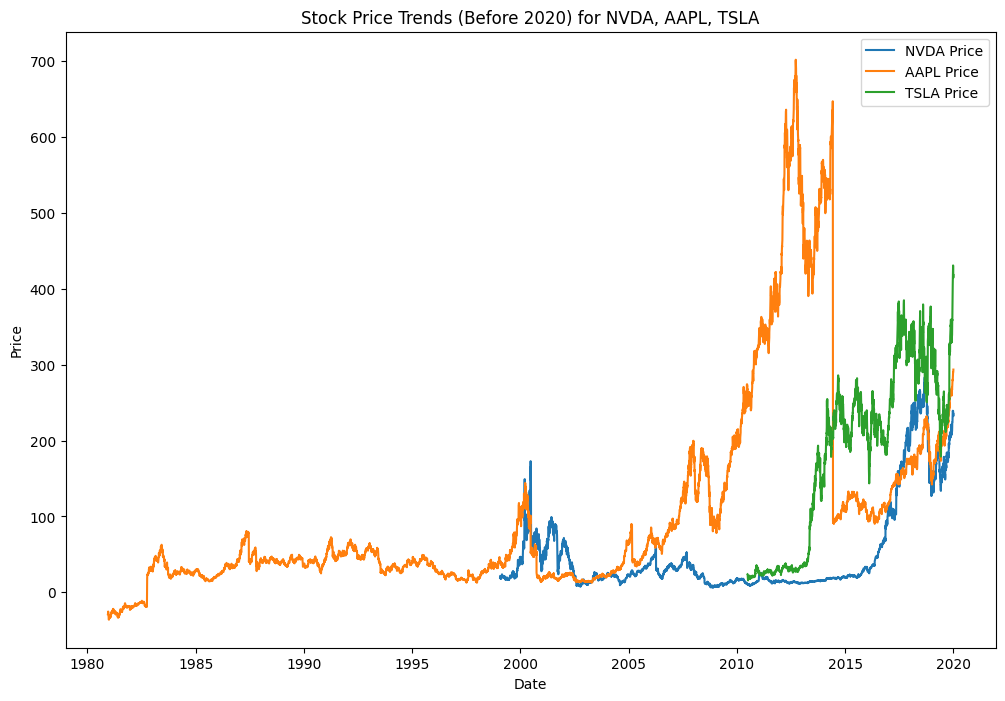

Failed to train model for PPL: cannot reindex on an axis with duplicate labels
Saved lightweight model for IEX to new_arima_lightweight/arima_model_IEX_pre_2020.pkl (787 bytes)
Saved lightweight model for GLW to new_arima_lightweight/arima_model_GLW_pre_2020.pkl (787 bytes)
Saved lightweight model for STX to new_arima_lightweight/arima_model_STX_pre_2020.pkl (787 bytes)
Saved lightweight model for ROL to new_arima_lightweight/arima_model_ROL_pre_2020.pkl (787 bytes)
Saved lightweight model for KMB to new_arima_lightweight/arima_model_KMB_pre_2020.pkl (787 bytes)
Failed to train model for CNP: cannot reindex on an axis with duplicate labels
Saved lightweight model for ABT to new_arima_lightweight/arima_model_ABT_pre_2020.pkl (787 bytes)
Saved lightweight model for D to new_arima_lightweight/arima_model_D_pre_2020.pkl (787 bytes)
Saved lightweight model for DE to new_arima_lightweight/arima_model_DE_pre_2020.pkl (787 bytes)
Saved lightweight model for HES to new_arima_lightweight/arima_m

'\nticker_to_test = \'AAPL\'\nmodel_file = os.path.join(output_folder, f\'arima_model_{ticker_to_test}_pre_2020.pkl\')\nwith open(model_file, \'rb\') as f:\n    model_data = pickle.load(f)\nparams = model_data[\'params\']\norder = model_data[\'order\']\nlast_p_obs = model_data[\'last_p_obs\']\nmodel = ARIMA(last_p_obs, order=order)\nmodel_fit = model.fit(start_params=params)\nforecast = model_fit.forecast(steps=1)\nprint(f"Forecast for {ticker_to_test}: {forecast}")\n'

In [2]:
# Cell 1: Import Libraries
import pandas as pd
import pyarrow.parquet as pq
from statsmodels.tsa.arima.model import ARIMA
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import chardet

%matplotlib inline

# Cell 2: Load and Filter Data
# Load the Parquet file
data_path = "data_mfin_7037_2024/crsp.dsf_trimmed_with_ticker.parquet"
table = pq.read_table(data_path)
df = table.to_pandas()

# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter data before 2020-01-01
train_df = df[df['date'] < '2020-01-01'].sort_values('date')

# Debug current working directory
print(f"Current working directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir()}")

# Load ticker lists from CSV files
index_folder = "index"  # Adjusted to relative path; change if needed

# Read S&P 500 tickers
sp500_file = os.path.join(index_folder, "sp500_constituents.csv")
try:
    sp500_df = pd.read_csv(sp500_file)
    sp500_tickers = sp500_df['Symbol'].tolist()
    print(f"Loaded {len(sp500_tickers)} S&P 500 tickers from {sp500_file}")
except FileNotFoundError:
    print(f"Error: {sp500_file} not found. Please ensure the file exists in {index_folder}.")
    sp500_tickers = []
except KeyError:
    print(f"Error: 'Symbol' column not found in {sp500_file}. Check column names.")
    sp500_tickers = []
except UnicodeDecodeError as e:
    print(f"Encoding error with {sp500_file}: {e}. Attempting to detect encoding...")
    with open(sp500_file, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
        print(f"Detected encoding: {encoding}")
    sp500_df = pd.read_csv(sp500_file, encoding=encoding)
    sp500_tickers = sp500_df['Symbol'].tolist()
    print(f"Loaded {len(sp500_tickers)} S&P 500 tickers with encoding {encoding}")

# Read Nasdaq-100 tickers
nasdaq_file = os.path.join(index_folder, "nasdaq_100.csv")
possible_ticker_columns = ['Symbol', 'Ticker', 'symbol', 'ticker']
try:
    nasdaq_df = pd.read_csv(nasdaq_file)
except UnicodeDecodeError as e:
    print(f"Encoding error with {nasdaq_file}: {e}. Attempting to detect encoding...")
    with open(nasdaq_file, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
        print(f"Detected encoding: {encoding}")
    nasdaq_df = pd.read_csv(nasdaq_file, encoding=encoding)

try:
    print(f"Columns in {nasdaq_file}: {nasdaq_df.columns.tolist()}")  # Debug column names
    ticker_column = next((col for col in possible_ticker_columns if col in nasdaq_df.columns), None)
    if ticker_column:
        nasdaq_tickers = nasdaq_df[ticker_column].tolist()
        print(f"Loaded {len(nasdaq_tickers)} Nasdaq-100 tickers from {nasdaq_file} using column '{ticker_column}'")
    else:
        raise KeyError("No recognizable ticker column found.")
except FileNotFoundError:
    print(f"Error: {nasdaq_file} not found. Please ensure the file exists in {index_folder}.")
    nasdaq_tickers = []
except KeyError as e:
    print(f"Error: {e}. Please check column names in {nasdaq_file} or provide a correct ticker column.")
    nasdaq_tickers = []

# Combine tickers from S&P 500 and Nasdaq-100, and find unique tickers
combined_tickers = list(set(sp500_tickers + nasdaq_tickers))
print(f"Total unique tickers combined from S&P 500 and Nasdaq-100: {len(combined_tickers)}")

# Filter train_df to only include combined unique tickers (case-insensitive match)
train_df = train_df[train_df['ticker'].str.upper().isin([t.upper() for t in combined_tickers])]
tickers = train_df['ticker'].unique()
print(f"Number of unique tickers in CRSP data: {len(tickers)}")

# Debug if no tickers match
if len(tickers) == 0:
    print("Warning: No tickers matched CRSP data. Checking sample tickers:")
    sample_crsp_tickers = df['ticker'].unique()[:10]
    print(f"Sample CRSP tickers: {sample_crsp_tickers}")
    print(f"Sample combined tickers: {combined_tickers[:10]}")

# Cell 3: Plot NVDA, AAPL, and TSLA Trends
plot_tickers = ['NVDA', 'AAPL', 'TSLA']
plt.figure(figsize=(12, 8))
for ticker in plot_tickers:
    if ticker in tickers:
        ticker_df = train_df[train_df['ticker'] == ticker][['date', 'prc']].set_index('date').dropna()
        if not ticker_df.empty:
            plt.plot(ticker_df['prc'], label=f'{ticker} Price')
        else:
            print(f"No data found for {ticker} before 2020.")
    else:
        print(f"{ticker} not in combined tickers or CRSP data.")

plt.title(f'Stock Price Trends (Before 2020) for NVDA, AAPL, TSLA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Cell 4: Train and Save Lightweight ARIMA Models
output_folder = "new_arima_lightweight"  # Unified folder for all models
os.makedirs(output_folder, exist_ok=True)

p, d, q = 1, 1, 0

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning, module="statsmodels")
    for ticker in tickers:
        try:
            ticker_df = train_df[train_df['ticker'] == ticker][['date', 'prc']].set_index('date').dropna()
            ticker_df = ticker_df.asfreq('B', method='ffill')
            if len(ticker_df) < p + d + 1:
                print(f"Skipping {ticker}: insufficient data ({len(ticker_df)} rows)")
                continue
            model = ARIMA(ticker_df['prc'], order=(p, d, q))
            model_fit = model.fit()
            lightweight_model = {
                'params': model_fit.params,
                'order': (p, d, q),
                'last_p_obs': ticker_df['prc'].iloc[-p:].values
            }
            model_file = os.path.join(output_folder, f'arima_model_{ticker}_pre_2020.pkl')
            with open(model_file, 'wb') as f:
                pickle.dump(lightweight_model, f, protocol=pickle.HIGHEST_PROTOCOL)
            file_size = os.path.getsize(model_file)
            print(f"Saved lightweight model for {ticker} to {model_file} ({file_size} bytes)")
        except Exception as e:
            print(f"Failed to train model for {ticker}: {str(e)}")

print(f"All lightweight models saved in '{output_folder}' folder.")

# Optional Cell 5: Example of Loading and Forecasting
"""
ticker_to_test = 'AAPL'
model_file = os.path.join(output_folder, f'arima_model_{ticker_to_test}_pre_2020.pkl')
with open(model_file, 'rb') as f:
    model_data = pickle.load(f)
params = model_data['params']
order = model_data['order']
last_p_obs = model_data['last_p_obs']
model = ARIMA(last_p_obs, order=order)
model_fit = model.fit(start_params=params)
forecast = model_fit.forecast(steps=1)
print(f"Forecast for {ticker_to_test}: {forecast}")
"""